## Imports

In [ ]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report


In [30]:

df = pd.read_csv("./dataset/heart.csv")

In [31]:
# Encode categorical features
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [32]:

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Reshape X for GRU input
X = X.reshape((X.shape[0], 1, X.shape[1]))


In [33]:
# Split data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [34]:
def objective(trial):
    # Define search space for hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    # Build GRU model
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(GRU(num_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        elif i == num_layers - 1:
            model.add(GRU(num_units, activation='relu'))
        else:
            model.add(GRU(num_units, activation='relu', return_sequences=True))
    
    model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model with early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # Evaluate model on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    return val_acc


In [35]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Get best hyperparameters
best_params = study.best_params



[I 2024-05-24 12:45:50,985] A new study created in memory with name: no-name-bc61a152-c409-4fcc-bf0b-d1696e304fa8


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\byomo\AppData\Local\Temp\ipykernel_9344\1090780275.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


[I 2024-05-24 12:46:02,614] Trial 0 finished with value: 0.8623188138008118 and parameters: {'num_layers': 3, 'num_units': 38, 'learning_rate': 0.000570264104522469}. Best is trial 0 with value: 0.8623188138008118.
[I 2024-05-24 12:46:09,030] Trial 1 finished with value: 0.8550724387168884 and parameters: {'num_layers': 1, 'num_units': 140, 'learning_rate': 0.0001908023785270756}. Best is trial 0 with value: 0.8623188138008118.
[I 2024-05-24 12:46:15,874] Trial 2 finished with value: 0.8913043737411499 and parameters: {'num_layers': 2, 'num_units': 90, 'learning_rate': 0.0012906614076743114}. Best is trial 2 with value: 0.8913043737411499.
[I 2024-05-24 12:46:24,437] Trial 3 finished with value: 0.9057971239089966 and parameters: {'num_layers': 3, 'num_units': 146, 'learning_rate': 0.0010802311315397577}. Best is trial 3 with value: 0.9057971239089966.
[I 2024-05-24 12:46:34,395] Trial 4 finished with value: 0.9057971239089966 and parameters: {'num_layers': 2, 'num_units': 149, 'learni

In [41]:
# Train final model with best hyperparameters
final_model = Sequential()
for i in range(best_params['num_layers']):
    if i == 0:
        final_model.add(GRU(best_params['num_units'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    elif i == best_params['num_layers'] - 1:
        final_model.add(GRU(best_params['num_units'], activation='relu'))
    else:
        final_model.add(GRU(best_params['num_units'], activation='relu', return_sequences=True))

final_model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_val, y_val))

# Evaluate final model on test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)

# Predict on test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)



Epoch 1/50
21/21 [==============================] - 5s 39ms/step - loss: 0.6844 - accuracy: 0.7492 - val_loss: 0.6631 - val_accuracy: 0.8551
Epoch 2/50
21/21 [==============================] - 0s 12ms/step - loss: 0.6374 - accuracy: 0.8178 - val_loss: 0.5761 - val_accuracy: 0.8551
Epoch 3/50
21/21 [==============================] - 0s 13ms/step - loss: 0.5243 - accuracy: 0.8380 - val_loss: 0.4176 - val_accuracy: 0.8478
Epoch 4/50
21/21 [==============================] - 0s 12ms/step - loss: 0.4043 - accuracy: 0.8474 - val_loss: 0.3468 - val_accuracy: 0.8406
Epoch 5/50
21/21 [==============================] - 0s 12ms/step - loss: 0.3708 - accuracy: 0.8505 - val_loss: 0.3460 - val_accuracy: 0.8478
Epoch 6/50
21/21 [==============================] - 0s 13ms/step - loss: 0.3541 - accuracy: 0.8551 - val_loss: 0.3541 - val_accuracy: 0.8551
Epoch 7/50
21/21 [==============================] - 0s 21ms/step - loss: 0.3489 - accuracy: 0.8520 - val_loss: 0.3467 - val_accuracy: 0.8696
Epoch 8/50
21

In [42]:
# Calculate additional performance metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
accuracy= accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
f1 = f1_score(y_test, y_pred, average='binary')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8840579710144928
Precision: 0.9240506329113924
Recall: 0.8795180722891566
F1 Score: 0.9012345679012346
ROC AUC Score: 0.9524644030668127


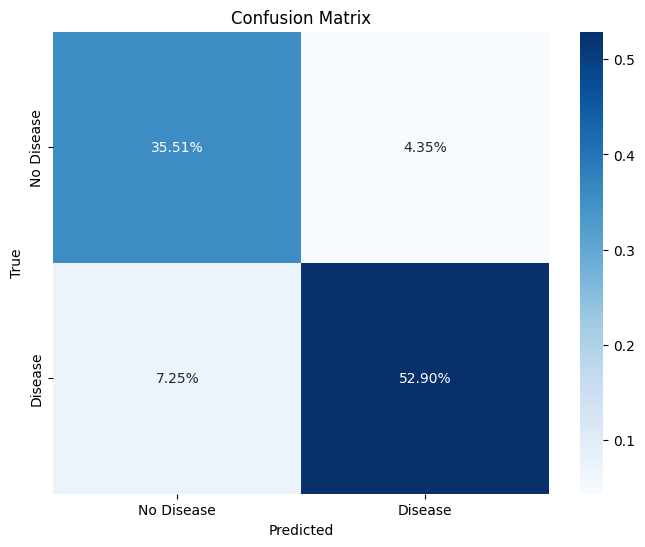

In [43]:
# Plot the confusion matrix using seaborn for better visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        55
           1       0.95      0.90      0.93        83

    accuracy                           0.91       138
   macro avg       0.91      0.92      0.91       138
weighted avg       0.92      0.91      0.91       138



## Saving the Model

In [44]:
'''# Save the model
final_model.save('./models/GRU.h5')'''
